# Prompt Engineering for Question Answering (QA)

This notebook explores different types of prompts on 3 local host llms for the task of **Question Answering (QA)** using **SQUAD** dataset, and compare their performance.
- Zero-shot prompting
- Few-shot prompting
- Role-based prompting
- Chain-of-Thought prompting

## 1.Load and Explore Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [21]:
# Load the SQuAD dataset
from datasets import load_dataset

dataset = load_dataset("squad", trust_remote_code=True)

In [22]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [23]:
for sample in dataset['train'].select(range(100,110)):
    print(sample)

{'id': '573387acd058e614000b5cb5', 'title': 'University_of_Notre_Dame', 'context': 'One of the main driving forces in the growth of the University was its football team, the Notre Dame Fighting Irish. Knute Rockne became head coach in 1918. Under Rockne, the Irish would post a record of 105 wins, 12 losses, and five ties. During his 13 years the Irish won three national championships, had five undefeated seasons, won the Rose Bowl in 1925, and produced players such as George Gipp and the "Four Horsemen". Knute Rockne has the highest winning percentage (.881) in NCAA Division I/FBS football history. Rockne\'s offenses employed the Notre Dame Box and his defenses ran a 7–2–2 scheme. The last game Rockne coached was on December 14, 1930 when he led a group of Notre Dame all-stars against the New York Giants in New York City.', 'question': 'In what year did the team lead by Knute Rockne win the Rose Bowl?', 'answers': {'text': ['1925'], 'answer_start': [354]}}
{'id': '573387acd058e614000b5

- Due to resource constraints, we will only use the first 1000 samples from the validation set.

In [24]:

squad = dataset['validation'].select(range(1000))
squad

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 1000
})

## 2. Define prompt templates

In [ ]:
# Define prompt templates
prompt_templates = {
    "zero_shot": """
Context: {context}
Question: {question}
Answer(briefly and accurately, no punctuation): 
    """,
    
    "few_shot": """
Context: The university is the major seat of the Congregation of Holy Cross (albeit not its official headquarters, which are in Rome). Its main seminary, Moreau Seminary, is located on the campus across St. Joseph lake from the Main Building. Old College, the oldest building on campus and located near the shore of St. Mary lake, houses undergraduate seminarians. Retired priests and brothers reside in Fatima House (a former retreat center), Holy Cross House, as well as Columba Hall near the Grotto. The university through the Moreau Seminary has ties to theologian Frederick Buechner. While not Catholic, Buechner has praised writers from Notre Dame and Moreau Seminary created a Buechner Prize for Preaching.
Question: What is the primary seminary of the Congregation of the Holy Cross?
Answer(briefly and accurately, no punctuation): Moreau Seminary

Context: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Question: What is in front of the Notre Dame Main Building?
Answer(briefly and accurately, no punctuation): a copper statue of Christ

Context: One of the main driving forces in the growth of the University was its football team, the Notre Dame Fighting Irish. Knute Rockne became head coach in 1918. Under Rockne, the Irish would post a record of 105 wins, 12 losses, and five ties. During his 13 years the Irish won three national championships, had five undefeated seasons, won the Rose Bowl in 1925, and produced players such as George Gipp and the "Four Horsemen". Knute Rockne has the highest winning percentage (.881) in NCAA Division I/FBS football history. Rockne's offenses employed the Notre Dame Box and his defenses ran a 7–2–2 scheme. The last game Rockne coached was on December 14, 1930 when he led a group of Notre Dame all-stars against the New York Giants in New York City.
Question: How many years was Knute Rockne head coach at Notre Dame?
Answer(briefly and accurately, no punctuation): 13

Context: {context}
Question: {question}
Answer(briefly and accurately, no punctuation):
    """,
    
    "role_based": """
You are an expert reading comprehension system that can accurately find answers in text.
Context: {context}
Question: {question}
Based on the context, the answer is(briefly and accurately, no full sentence, no ending punctuation):
    """,

    "cot": """
Context: {context}
Question: {question}
To answer this question, follow these steps:
1. Understand what the question is asking for
2. Look for relevant information in the context
3. Extract the precise answer from the context
4. Verify the answer matches what was asked
5. Answer the question briefly and accurately without punctuation
Answer: 
"""
}

## 3. Helper Functions

### 3.1 Call Local LMStudio model

In [27]:
# Function to call local LMStudio model
import requests


def call_lmstudio_api(prompt, url="http://localhost:1234/v1/chat/completions"):
    headers = {
        "Content-Type": "application/json"
    }
    data = {
        "messages": [{"role": "user", "content": prompt}],
        "temperature": 0.0,
        "max_tokens": 100
    }
    
    response = requests.post(url, headers=headers, json=data)
    if response.status_code == 200:
        return response.json()["choices"][0]["message"]["content"]
    else:
        print(f"Error: {response.status_code}")
        print(response.text)
        return "Error in API call"


### 3.2 Evaluate Answer

In [ ]:
from collections import Counter

def evaluate_answer(prediction, ground_truth):
    # Exact Match
    exact_match = int(prediction.lower().rstrip('.!?,;:') == ground_truth.strip().lower().rstrip('.!?,;:'))
    
    pred_tokens = prediction.lower().rstrip('.!?,;:').split()
    truth_tokens = ground_truth.lower().rstrip('.!?,;:').split()
    
    if not pred_tokens or not truth_tokens:
        return {"exact_match": exact_match, "f1": 0.0}
    
    pred_counter = Counter(pred_tokens)
    truth_counter = Counter(truth_tokens)
    
    common = pred_counter & truth_counter 
    num_same = sum(common.values())
    
    if num_same == 0:
        return {"exact_match": exact_match, "f1": 0.0}
    
    precision = num_same / len(pred_tokens)
    recall = num_same / len(truth_tokens)
    f1 = 2 * precision * recall / (precision + recall)
    
    return {
        "exact_match": exact_match,
        "f1": round(f1, 4)
    }


## 4. Main Loop

- Due to system resouce constraints, we will manually switch between the different local llm models.

In [29]:
# Select a subset of examples for testing
num_examples = 500
examples = squad.select(range(num_examples))

# Initialize results dictionary
results = {}

### 4.1 Llama-3B

In [ ]:
#  Llama-3.2-3b-instruct
import json
import time

model_name = "llama-3.2-3b-instruct"
print(f"Running experiment for {model_name}...")
results[model_name] = {prompt_type: [] for prompt_type in prompt_templates}

start_time = time.time()

for i, example in enumerate(examples):
    context = example["context"]
    question = example["question"]
    answer = example["answers"]["text"][0]
    
    for prompt_type, template in prompt_templates.items():
        # Format the prompt
        prompt = template.format(context=context, question=question)
        
        # Call LMStudio API
        print(f"Example {i+1}/{num_examples}, Prompt: {prompt_type}, Model: {model_name}")
        response = call_lmstudio_api(prompt)
        metrics = evaluate_answer(response, answer)
        
        results[model_name][prompt_type].append({
            "example_id": i,
            "context": context,
            "question": question,
            "ground_truth": answer,
            "prediction": response,
            "metrics": metrics
        })
        

end_time = time.time()
print(f"\n\nTime taken for {model_name}: {end_time - start_time:.2f} seconds")

print(f"Completed with {model_name}.")

Running experiment for llama-3.2-3b-instruct...
Example 1/500, Prompt: zero_shot, Model: llama-3.2-3b-instruct
Example 1/500, Prompt: few_shot, Model: llama-3.2-3b-instruct
Example 1/500, Prompt: role_based, Model: llama-3.2-3b-instruct
Example 1/500, Prompt: cot, Model: llama-3.2-3b-instruct
Example 2/500, Prompt: zero_shot, Model: llama-3.2-3b-instruct
Example 2/500, Prompt: few_shot, Model: llama-3.2-3b-instruct
Example 2/500, Prompt: role_based, Model: llama-3.2-3b-instruct
Example 2/500, Prompt: cot, Model: llama-3.2-3b-instruct
Example 3/500, Prompt: zero_shot, Model: llama-3.2-3b-instruct
Example 3/500, Prompt: few_shot, Model: llama-3.2-3b-instruct
Example 3/500, Prompt: role_based, Model: llama-3.2-3b-instruct
Example 3/500, Prompt: cot, Model: llama-3.2-3b-instruct
Example 4/500, Prompt: zero_shot, Model: llama-3.2-3b-instruct
Example 4/500, Prompt: few_shot, Model: llama-3.2-3b-instruct
Example 4/500, Prompt: role_based, Model: llama-3.2-3b-instruct
Example 4/500, Prompt: co

## 4.2 Gemma-1B

In [ ]:
# gemma-3-1b-it
import json
import time

model_name = "gemma-3-1b-it"
print(f"Running experiment for {model_name}...")
results[model_name] = {prompt_type: [] for prompt_type in prompt_templates}

start_time = time.time()

for i, example in enumerate(examples):
    context = example["context"]
    question = example["question"]
    answer = example["answers"]["text"][0]
    
    for prompt_type, template in prompt_templates.items():
        # Format the prompt
        prompt = template.format(context=context, question=question)
        
        # Call LMStudio API
        print(f"Example {i+1}/{num_examples}, Prompt: {prompt_type}, Model: {model_name}")
        response = call_lmstudio_api(prompt)
        metrics = evaluate_answer(response, answer)
        
        results[model_name][prompt_type].append({
            "example_id": i,
            "context": context,
            "question": question,
            "ground_truth": answer,
            "prediction": response,
            "metrics": metrics
        })
        

end_time = time.time()
print(f"\n\nTime taken for {model_name}: {end_time - start_time:.2f} seconds")


print(f"Completed with {model_name}.")

Running experiment for gemma-3-1b-it...
Example 1/500, Prompt: zero_shot, Model: gemma-3-1b-it
Example 1/500, Prompt: few_shot, Model: gemma-3-1b-it
Example 1/500, Prompt: role_based, Model: gemma-3-1b-it
Example 1/500, Prompt: cot, Model: gemma-3-1b-it
Example 2/500, Prompt: zero_shot, Model: gemma-3-1b-it
Example 2/500, Prompt: few_shot, Model: gemma-3-1b-it
Example 2/500, Prompt: role_based, Model: gemma-3-1b-it
Example 2/500, Prompt: cot, Model: gemma-3-1b-it
Example 3/500, Prompt: zero_shot, Model: gemma-3-1b-it
Example 3/500, Prompt: few_shot, Model: gemma-3-1b-it
Example 3/500, Prompt: role_based, Model: gemma-3-1b-it
Example 3/500, Prompt: cot, Model: gemma-3-1b-it
Example 4/500, Prompt: zero_shot, Model: gemma-3-1b-it
Example 4/500, Prompt: few_shot, Model: gemma-3-1b-it
Example 4/500, Prompt: role_based, Model: gemma-3-1b-it
Example 4/500, Prompt: cot, Model: gemma-3-1b-it
Example 5/500, Prompt: zero_shot, Model: gemma-3-1b-it
Example 5/500, Prompt: few_shot, Model: gemma-3-1

## 4.3 Qwen-0.5b

In [ ]:
# qwen2.5-0.5b-instruct-mlx
import json
import time

model_name = "qwen2.5-0.5b-instruct-mlx"
print(f"Running experiment for {model_name}...")
results[model_name] = {prompt_type: [] for prompt_type in prompt_templates}

start_time = time.time()

for i, example in enumerate(examples):
    context = example["context"]
    question = example["question"]
    answer = example["answers"]["text"][0]
    
    for prompt_type, template in prompt_templates.items():
        # Format the prompt
        prompt = template.format(context=context, question=question)
        
        # Call LMStudio API
        print(f"Example {i+1}/{num_examples}, Prompt: {prompt_type}, Model: {model_name}")
        response = call_lmstudio_api(prompt)
        metrics = evaluate_answer(response, answer)
        
        results[model_name][prompt_type].append({
            "example_id": i,
            "context": context,
            "question": question,
            "ground_truth": answer,
            "prediction": response,
            "metrics": metrics
        })
        
        # # Wait to avoid rate limiting
        # time.sleep(1)

end_time = time.time()
print(f"\n\nTime taken for {model_name}: {end_time - start_time:.2f} seconds")


print(f"Completed with {model_name}.")

Running experiment for qwen2.5-0.5b-instruct-mlx...
Example 1/500, Prompt: zero_shot, Model: qwen2.5-0.5b-instruct-mlx
Example 1/500, Prompt: few_shot, Model: qwen2.5-0.5b-instruct-mlx
Example 1/500, Prompt: role_based, Model: qwen2.5-0.5b-instruct-mlx
Example 1/500, Prompt: cot, Model: qwen2.5-0.5b-instruct-mlx
Example 2/500, Prompt: zero_shot, Model: qwen2.5-0.5b-instruct-mlx
Example 2/500, Prompt: few_shot, Model: qwen2.5-0.5b-instruct-mlx
Example 2/500, Prompt: role_based, Model: qwen2.5-0.5b-instruct-mlx
Example 2/500, Prompt: cot, Model: qwen2.5-0.5b-instruct-mlx
Example 3/500, Prompt: zero_shot, Model: qwen2.5-0.5b-instruct-mlx
Example 3/500, Prompt: few_shot, Model: qwen2.5-0.5b-instruct-mlx
Example 3/500, Prompt: role_based, Model: qwen2.5-0.5b-instruct-mlx
Example 3/500, Prompt: cot, Model: qwen2.5-0.5b-instruct-mlx
Example 4/500, Prompt: zero_shot, Model: qwen2.5-0.5b-instruct-mlx
Example 4/500, Prompt: few_shot, Model: qwen2.5-0.5b-instruct-mlx
Example 4/500, Prompt: role_b

In [33]:
results

{'llama-3.2-3b-instruct': {'zero_shot': [{'example_id': 0,
    'context': 'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.',
    'question': 'Which NFL team represented the AFC at Super Bowl 50?',
    'ground_truth': 'Denver Broncos',
    'prediction': 'Denver Broncos',


In [44]:
results["llama-3.2-3b-instruct"]["few_shot"]

[{'example_id': 0,
  'context': 'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.',
  'question': 'Which NFL team represented the AFC at Super Bowl 50?',
  'ground_truth': 'Denver Broncos',
  'prediction': 'Denver Broncos',
  'metrics': {'exact_match': 1, 'f1': 1.0}},
 {'

In [40]:
# Save results to a JSON file
with open('qa_prompt_results.json', 'w') as f:
    json.dump(results, f)

print("Results saved to qa_prompt_results.json")

Results saved to qa_prompt_results.json


In [95]:
# Load results from JSON file
with open('qa_prompt_results.json', 'r') as f:
    results = json.load(f)

print("Results loaded from qa_prompt_results.json")

Results loaded from qa_prompt_results.json


## 5. Comparison

### 5.1 Overall Performance Metrics 

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate average metrics for each prompt type and model
summary = {}
for model_name in results:
    summary[model_name] = {}
    for prompt_type in prompt_templates:
        exact_matches = [result["metrics"]["exact_match"] for result in results[model_name][prompt_type]]
        f1_scores = [result["metrics"]["f1"] for result in results[model_name][prompt_type]]
        
        summary[model_name][prompt_type] = {
            "exact_match": sum(exact_matches) / len(exact_matches) if exact_matches else 0,
            "f1": round(sum(f1_scores) / len(f1_scores), 3) if f1_scores else 0
        }


In [97]:
summary

{'llama-3.2-3b-instruct': {'zero_shot': {'exact_match': 0.55, 'f1': 0.734},
  'few_shot': {'exact_match': 0.26, 'f1': 0.4},
  'role_based': {'exact_match': 0.548, 'f1': 0.805},
  'cot': {'exact_match': 0.178, 'f1': 0.316}},
 'gemma-3-1b-it': {'zero_shot': {'exact_match': 0.59, 'f1': 0.707},
  'few_shot': {'exact_match': 0.456, 'f1': 0.599},
  'role_based': {'exact_match': 0.606, 'f1': 0.691},
  'cot': {'exact_match': 0.198, 'f1': 0.408}},
 'qwen2.5-0.5b-instruct-mlx': {'zero_shot': {'exact_match': 0.0, 'f1': 0.161},
  'few_shot': {'exact_match': 0.05, 'f1': 0.234},
  'role_based': {'exact_match': 0.06, 'f1': 0.287},
  'cot': {'exact_match': 0.004, 'f1': 0.123}}}

In [98]:
# Create a table comparing performance metrics across models and prompt types
def create_performance_table(results, metric="exact_match"):
    """Create a DataFrame showing performance across models and prompt types."""
    data = {}
    
    for model_name in results:
        model_data = {}
        for prompt_type in results[model_name]:
            scores = [item["metrics"][metric] for item in results[model_name][prompt_type]]
            model_data[prompt_type] = np.mean(scores) if scores else 0
        data[model_name] = model_data
    
    return pd.DataFrame(data).T

# Create tables for both metrics
exact_match_table = create_performance_table(results, "exact_match")
f1_table = create_performance_table(results, "f1")

print("Exact Match Rate:")
print(exact_match_table)
print("\nF1 Score:")
print(f1_table)

Exact Match Rate:
                           zero_shot  few_shot  role_based    cot
llama-3.2-3b-instruct           0.55     0.260       0.548  0.178
gemma-3-1b-it                   0.59     0.456       0.606  0.198
qwen2.5-0.5b-instruct-mlx       0.00     0.050       0.060  0.004

F1 Score:
                           zero_shot  few_shot  role_based    cot
llama-3.2-3b-instruct          0.734     0.400       0.805  0.316
gemma-3-1b-it                  0.707     0.599       0.691  0.408
qwen2.5-0.5b-instruct-mlx      0.161     0.234       0.287  0.123


### 5.2 Exact Match and F1 across Prompt Types

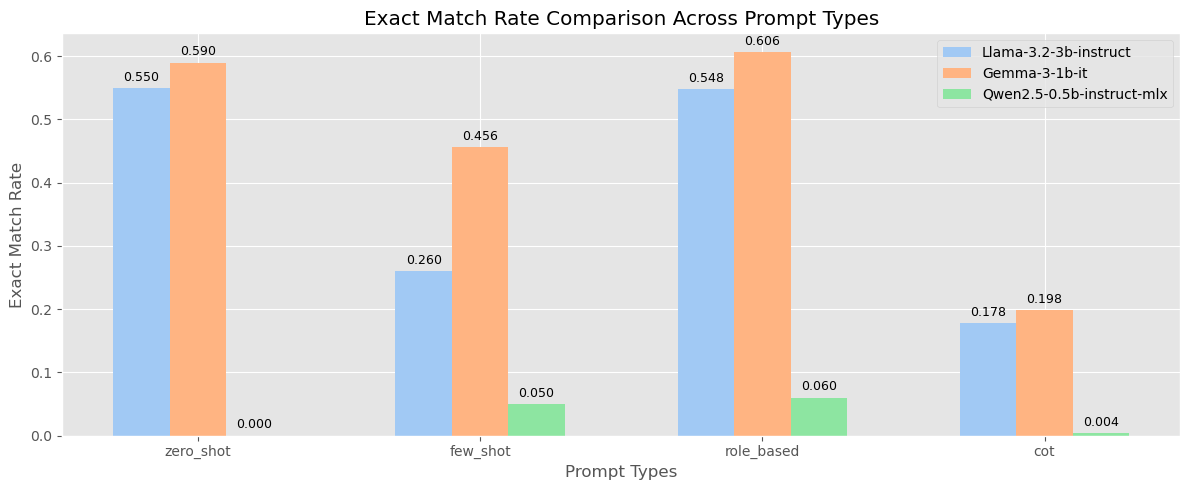

In [99]:
# Create visualization for Exact Match comparison
plt.figure(figsize=(12, 5))
sns.set_palette("pastel")

prompt_types = list(prompt_templates.keys())
x = np.arange(len(prompt_types))
width = 0.2 
models = list(results.keys())

# Create the bar plot and save the containers
containers = []
for i, model_name in enumerate(models):
    exact_match_scores = [summary[model_name][pt]["exact_match"] for pt in prompt_types]
    container = plt.bar(x + (i - 1) * width, exact_match_scores, width, label=model_name.capitalize())
    containers.append(container)

plt.xlabel('Prompt Types')
plt.ylabel('Exact Match Rate')
plt.title('Exact Match Rate Comparison Across Prompt Types')
plt.xticks(x, prompt_types)
plt.legend()

# Add labels on top of each bar
for container in containers:
    plt.bar_label(container, fmt='%.3f', padding=3, fontsize=9)

plt.tight_layout()
plt.savefig('exact_match_comparison.png')
plt.show()

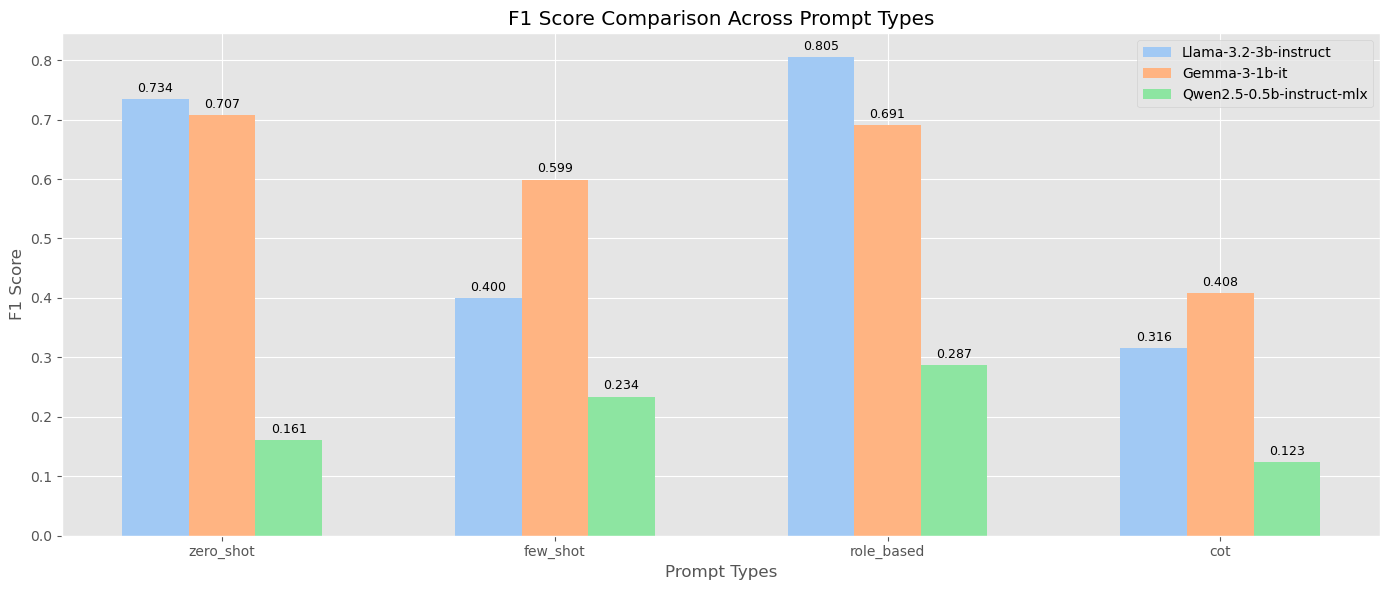

In [100]:
# Create visualization for F1 Score comparison
plt.figure(figsize=(14, 6))
sns.set_palette("pastel")

# Create the bar plot and save the containers
containers = []
for i, model_name in enumerate(models):
    f1_scores = [summary[model_name][pt]["f1"] for pt in prompt_types]
    container = plt.bar(x + (i - 1) * width, f1_scores, width, label=model_name.capitalize())
    containers.append(container)

plt.xlabel('Prompt Types')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison Across Prompt Types')
plt.xticks(x, prompt_types)
plt.legend()

# Add labels on top of each bar
for container in containers:
    plt.bar_label(container, fmt='%.3f', padding=3, fontsize=9)

plt.tight_layout()
plt.savefig('f1_score_comparison.png')
plt.show()

### 5.3 EM and F1 Across Models

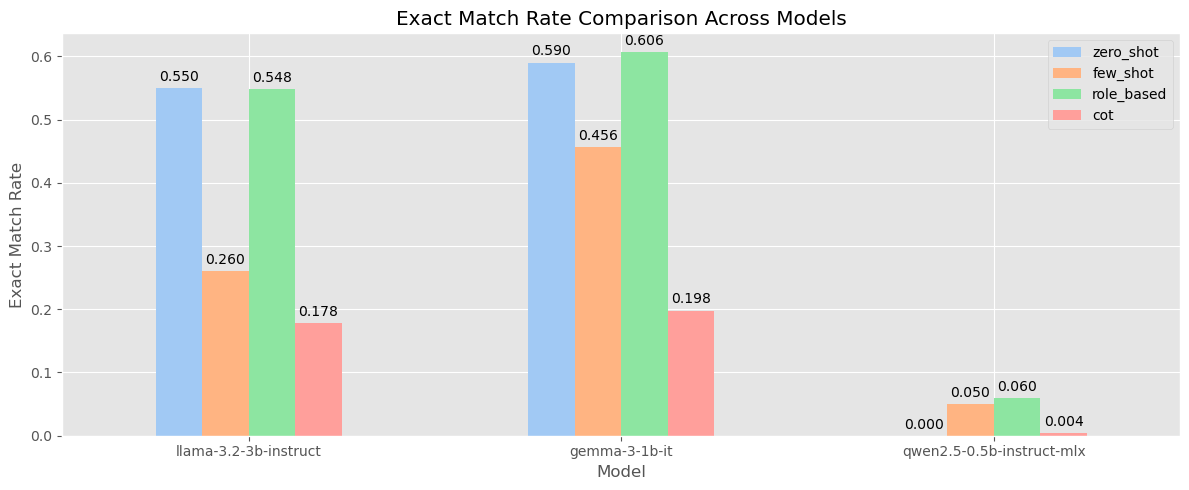

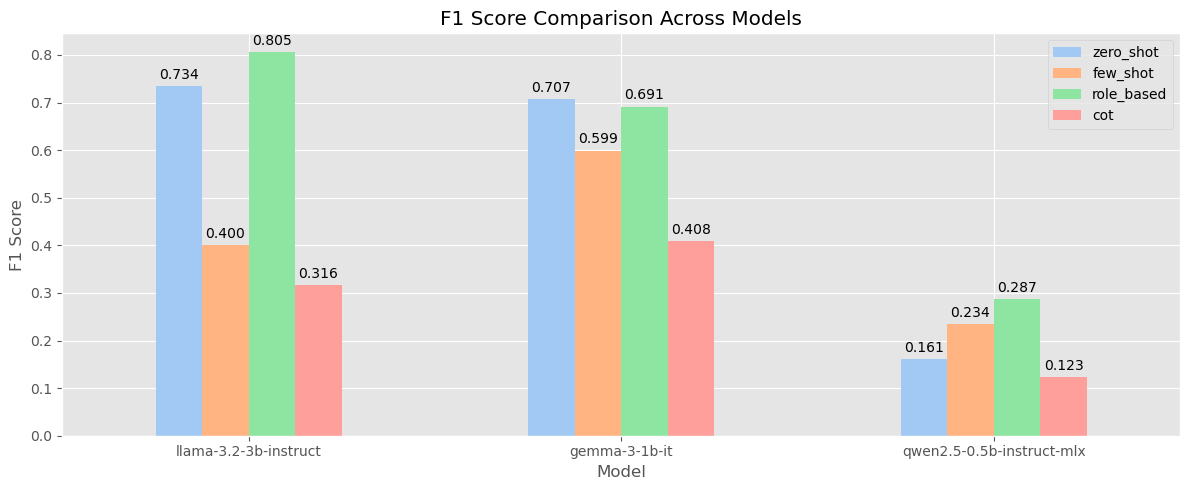

In [101]:
# Set up the visualization style
plt.style.use('ggplot')
sns.set_palette("pastel")

# Function to create a grouped bar chart
def plot_performance_comparison(data, metric_name, title):
    fig, ax = plt.subplots(figsize=(12, 5))
    
    # Plot the data
    data.plot(kind='bar', ax=ax)
    
    # Add labels and title
    ax.set_xlabel('Model')
    ax.set_ylabel(metric_name)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

    # Add value labels on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3)
    
    plt.tight_layout()
    return fig

# Create the visualizations
exact_match_fig = plot_performance_comparison(
    exact_match_table, 
    'Exact Match Rate', 
    'Exact Match Rate Comparison Across Models'
)

f1_fig = plot_performance_comparison(
    f1_table, 
    'F1 Score', 
    'F1 Score Comparison Across Models'
)

# Save the figures
exact_match_fig.savefig('exact_match_comparison_detailed.png')
f1_fig.savefig('f1_score_comparison_detailed.png')


### 5.4 Prompt Type Difference Analysis

In [102]:
def find_divergent_cases(results, min_difference=0.5):
    """Find examples where different prompt types produced notably different results."""
    divergent_cases = {}
    
    for model_name in results:
        model_divergent = []
        
        # Get all example IDs for this model
        example_ids = set([item["example_id"] for item in results[model_name]["zero_shot"]])
        
        for ex_id in example_ids:
            # Collect performance and predictions for each prompt type
            case_data = {}
            for prompt_type in results[model_name]:
                for item in results[model_name][prompt_type]:
                    if item["example_id"] == ex_id:
                        case_data[prompt_type] = {
                            "f1": item["metrics"]["f1"],
                            "prediction": item["prediction"]
                        }
                        # Keep context, question, ground_truth for reference
                        context = item["context"]
                        question = item["question"]
                        ground_truth = item["ground_truth"]
                        break
            
            # Calculate max difference in F1 scores
            f1_scores = [data["f1"] for data in case_data.values()]
            max_diff = max(f1_scores) - min(f1_scores)
            
            if max_diff >= min_difference:
                divergent_case = {
                    "context": context,
                    "question": question,
                    "ground_truth": ground_truth,
                    "model_name": model_name,
                    "prompt_results": case_data,
                    "max_diff": max_diff
                }
                model_divergent.append(divergent_case)
        
        divergent_cases[model_name] = model_divergent
    
    return divergent_cases

# Find cases with divergent results across prompt types
divergent_cases = find_divergent_cases(results, min_difference=0.7)

# Display a few divergent cases for each model
for model_name, cases in divergent_cases.items():
    print(f"\nDivergent Cases for {model_name}:")
    
    # Sort by max difference
    sorted_cases = sorted(cases, key=lambda x: x['max_diff'], reverse=True)
    
    # Display top 5 cases
    for i, case in enumerate(sorted_cases[:5]):
        print(f"\nCase {i+1}:")
        # print(f"Context: {case['context']}")
        print(f"Question: {case['question']}")
        print(f"Ground Truth: {case['ground_truth']}")
        print(f"Max F1 Difference: {case['max_diff']:.4f}")
        
        print("Results by prompt type:")
        for prompt_type, data in case["prompt_results"].items():
            print(f"  {prompt_type}: F1={data['f1']:.4f}, Prediction='{data['prediction']}'")


Divergent Cases for llama-3.2-3b-instruct:

Case 1:
Question: Which NFL team won Super Bowl 50?
Ground Truth: Denver Broncos
Max F1 Difference: 1.0000
Results by prompt type:
  zero_shot: F1=1.0000, Prediction='Denver Broncos'
  few_shot: F1=0.0000, Prediction='Here are the answers:

1. The primary seminary of the Congregation of the Holy Cross is Moreau Seminary.

2. A copper statue of Christ with arms upraised and the legend "Venite Ad Me Omnes" is in front of the Main Building.

3. Knute Rockne was head coach at Notre Dame for 13 years.'
  role_based: F1=1.0000, Prediction='Denver Broncos.'
  cot: F1=0.0563, Prediction='1. The question is asking for the name of the NFL team that won Super Bowl 50.
2. Looking at the context, it mentions that the Denver Broncos defeated the Carolina Panthers 24–10 to earn their third Super Bowl title.
3. The precise answer from the context is Denver Broncos
4. The answer matches what was asked as it states which team won Super Bowl 50
5. Denver Bronc

### 5.5 Prompt Design Bias Analysis(with Llama)


Raw data for Llama model prompt bias analysis:
     prompt_type question_type     f1  exact_match
0      zero_shot         other  1.000            1
1      zero_shot         other  1.000            1
2      zero_shot         where  0.444            0
3      zero_shot         other  1.000            1
4      zero_shot          what  1.000            1
...          ...           ...    ...          ...
1995         cot          when  0.923            0
1996         cot          what  0.750            0
1997         cot         where  0.800            0
1998         cot          what  0.375            0
1999         cot          what  1.000            1

[2000 rows x 4 columns]

Average F1 scores by prompt type and question type:
   prompt_type question_type     f1
0          cot           how  0.241
1          cot         other  0.251
2          cot          what  0.347
3          cot          when  0.301
4          cot         where  0.262
5          cot           who  0.410
6     few_

<Figure size 1400x800 with 0 Axes>

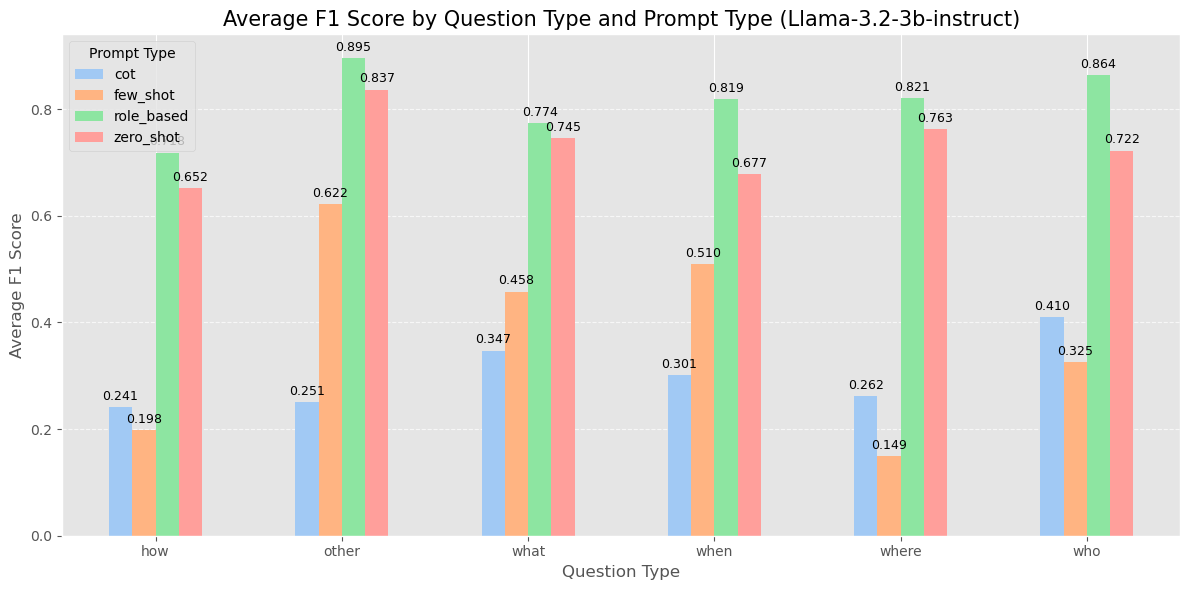

In [104]:
def analyze_prompt_bias_llama(results):
    """Analyze if certain prompt types favor specific types of questions for Llama model only."""
    # Categorize questions by type
    def categorize_question(question):
        question = question.lower()
        if question.startswith('who'):
            return 'who'
        elif question.startswith('what'):
            return 'what'
        elif question.startswith('when'):
            return 'when'
        elif question.startswith('where'):
            return 'where'
        elif question.startswith('why'):
            return 'why'
        elif question.startswith('how'):
            return 'how'
        else:
            return 'other'
    
    bias_data = []
    
    # Extract only Llama model data
    llama_model = "llama-3.2-3b-instruct"  # Adjust the exact name if needed
    
    for prompt_type in results[llama_model]:
        for item in results[llama_model][prompt_type]:
            question_type = categorize_question(item["question"])
            
            bias_data.append({
                "prompt_type": prompt_type,
                "question_type": question_type,
                "f1": item["metrics"]["f1"],
                "exact_match": item["metrics"]["exact_match"]
            })
    
    return pd.DataFrame(bias_data)

# Analyze prompt bias by question type for Llama model only
llama_bias_df = analyze_prompt_bias_llama(results)

# Print the raw data frame
print("\nRaw data for Llama model prompt bias analysis:")
print(llama_bias_df)

# Create a grouped bar chart instead of heatmap
plt.figure(figsize=(14, 8))

# Calculate average F1 score by prompt type and question type
avg_f1_by_type = llama_bias_df.groupby(['prompt_type', 'question_type'])['f1'].mean().reset_index()

# Print the aggregated data
print("\nAverage F1 scores by prompt type and question type:")
print(avg_f1_by_type)

# Pivot the data for easier plotting
pivot_data = avg_f1_by_type.pivot(index='question_type', columns='prompt_type', values='f1')

# Print the pivoted data
print("\nPivoted data for plotting:")
print(pivot_data)

# Plot with question types on x-axis and different colors for prompt types
ax = pivot_data.plot(kind='bar', figsize=(12, 6))
plt.title('Average F1 Score by Question Type and Prompt Type (Llama-3.2-3b-instruct)', fontsize=15)
plt.xlabel('Question Type', fontsize=12)
plt.ylabel('Average F1 Score', fontsize=12)
plt.legend(title='Prompt Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=9)

plt.tight_layout()
plt.savefig('llama_question_type_bias_barchart.png')

# Calculate the "best" prompt type for each question type
best_prompt_by_question = avg_f1_by_type.loc[avg_f1_by_type.groupby('question_type')['f1'].idxmax()]
best_prompt_by_question = best_prompt_by_question.sort_values('f1', ascending=False)

print("\nBest Prompt Type for Each Question Type:")
for _, row in best_prompt_by_question.iterrows():
    print(f"Question type '{row['question_type']}': Best prompt is '{row['prompt_type']}' (F1={row['f1']:.3f})")

# Calculate overall prompt type performance
overall_prompt_performance = llama_bias_df.groupby('prompt_type')['f1'].mean().sort_values(ascending=False)
print("\nOverall Prompt Type Performance:")
for prompt_type, avg_f1 in overall_prompt_performance.items():
    print(f"Prompt type '{prompt_type}': Average F1={avg_f1:.3f}")

# Print detailed statistics for each prompt type and question type combination
print("\nDetailed Statistics by Prompt Type and Question Type:")
detailed_stats = llama_bias_df.groupby(['prompt_type', 'question_type']).agg({
    'f1': ['mean', 'std', 'min', 'max', 'count'],
    'exact_match': ['mean', 'sum', 'count']
}).round(3)
print(detailed_stats)

# Print correlation between metrics
print("\nCorrelation between F1 and Exact Match:")
print(llama_bias_df[['f1', 'exact_match']].corr())